# Setup
---

In [1]:
load_or_install_packages <- function(packages){
    for(package in packages){
        if(!require(package, character.only = TRUE)) {
            install.packages(i, dependencies = TRUE)
            require(package, character.only = TRUE)
        }
    }
}

In [2]:
# Load required packages, or install them if they don't already exist.
packages <- c("bayesplot", "ggplot2", "loo", "rstan")
load_or_install_packages(packages)

theme_set(bayesplot::theme_default())

Loading required package: bayesplot
This is bayesplot version 1.4.0
- Plotting theme set to bayesplot::theme_default()
- Online documentation at mc-stan.org/bayesplot
Loading required package: ggplot2
Loading required package: loo
This is loo version 1.1.0
Loading required package: rstan
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


# Load and examine data
---

In [3]:
# Loads vector of counts 'y'
source("../data/count-data.R")
N <- length(y)
print(N)
print(y)

[1] 500
  [1] 0 3 5 0 4 7 4 2 3 6 7 0 0 3 7 5 5 0 4 0 4 4 6 3 7 5 3 0 0 2 0 1 0 1 5 4 4
 [38] 2 3 6 4 5 0 7 7 4 4 4 0 6 1 5 6 5 6 7 3 6 2 3 0 2 0 6 6 0 3 4 4 5 5 0 5 7
 [75] 5 5 6 4 2 3 4 6 4 6 6 4 0 6 5 5 7 0 1 6 7 0 5 0 0 5 6 5 1 0 7 1 2 6 5 4 0
[112] 4 0 4 4 6 3 0 0 3 3 4 2 5 3 4 3 2 5 2 4 4 0 2 7 5 7 5 5 7 7 0 4 6 0 4 6 7
[149] 4 0 4 1 5 0 3 5 7 6 0 5 5 6 7 6 7 3 4 3 7 7 2 5 4 5 5 0 6 2 4 5 4 0 0 5 5
[186] 7 7 0 3 0 3 3 6 1 4 2 0 4 7 5 5 0 3 7 0 6 6 4 1 6 7 6 0 3 6 4 7 0 5 5 4 0
[223] 0 2 4 6 0 5 0 2 7 2 7 5 4 6 2 4 0 4 0 0 3 5 4 3 5 5 7 7 0 6 4 5 1 5 3 5 5
[260] 5 0 2 7 6 2 3 2 5 4 7 6 7 3 3 4 4 6 4 6 7 1 5 6 3 3 6 3 4 0 7 0 3 6 5 0 0
[297] 0 5 4 4 0 4 7 5 5 3 3 0 0 5 4 0 7 6 0 6 2 0 6 1 0 4 0 4 3 0 4 5 5 7 6 6 5
[334] 4 7 0 6 4 7 7 5 0 1 4 7 6 4 5 4 7 2 5 2 6 3 2 7 4 3 4 6 6 6 6 7 1 0 0 7 7
[371] 4 2 4 5 5 7 4 1 7 6 5 6 5 4 0 0 7 0 0 5 6 6 3 6 0 0 0 4 4 3 0 7 5 4 2 7 0
[408] 4 0 0 2 4 5 0 4 2 5 2 0 6 6 3 6 0 2 5 0 0 0 6 0 0 6 5 4 6 4 5 5 4 0 3 4 3
[445] 3 5 3 4 5 7 0 0 1 4 6 3 5 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


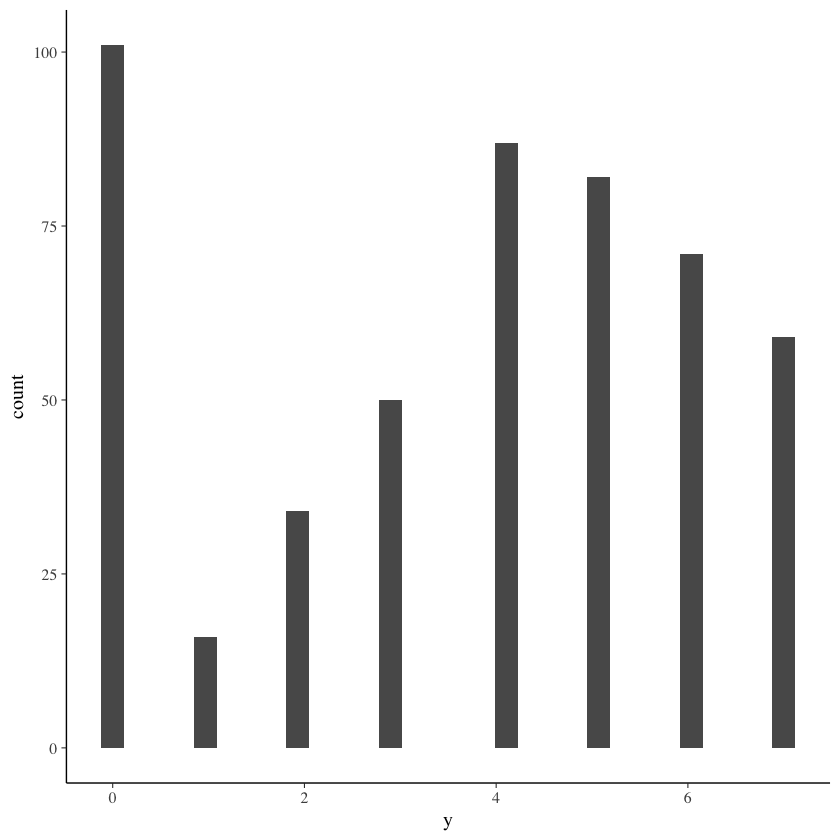

In [4]:
qplot(y)

## Compare our data to draws from Poisson with same mean

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


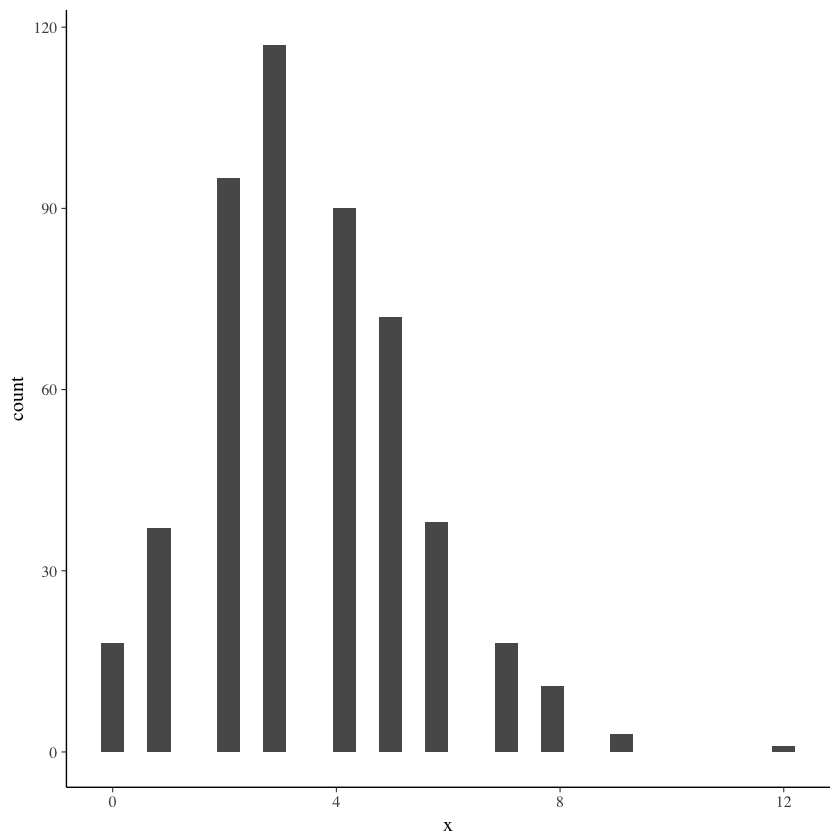

In [5]:
x <- rpois(N, lambda = mean(y))
qplot(x)

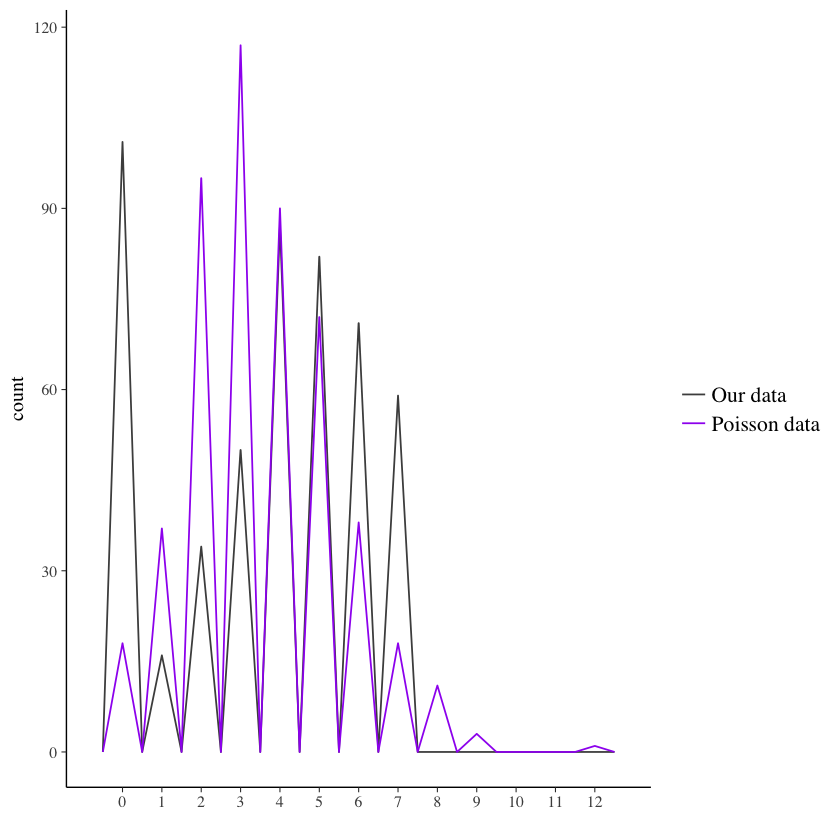

In [6]:
plotdata <- data.frame(
  value = c(y, x), 
  variable = rep(c("Our data", "Poisson data"), each = N)
)

# Frequency polygons
ggplot(plotdata, aes(x = value, color = variable)) + 
  geom_freqpoly(binwidth = 0.5) +
  scale_x_continuous(name = '', breaks = 0:max(x,y)) +
  scale_color_manual(name = '', values = c("gray30", "purple"))

## Side by side bar plots

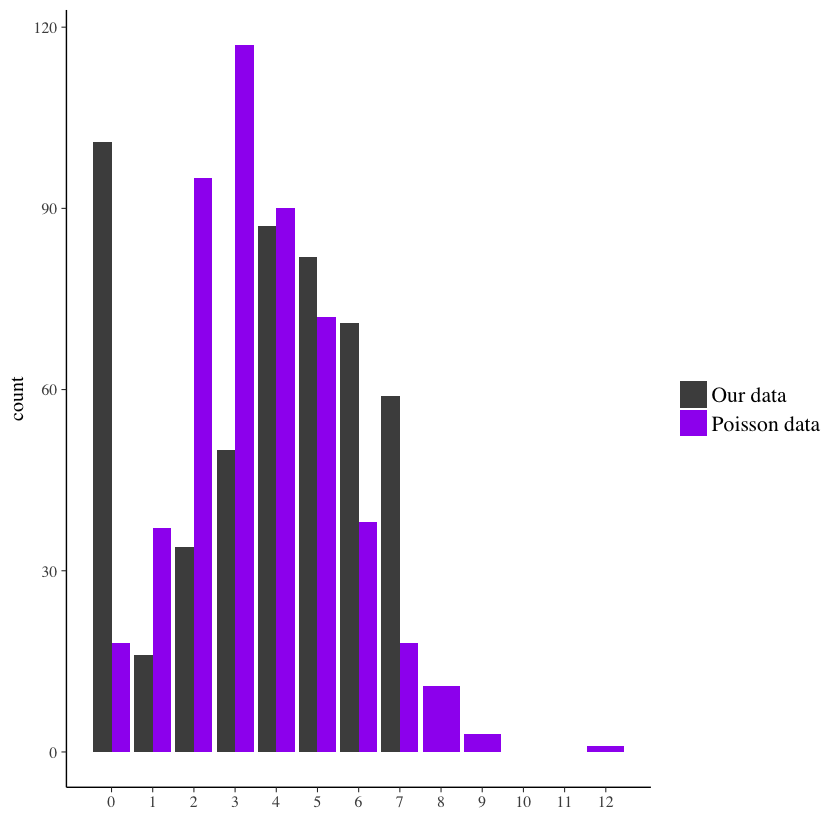

In [7]:
ggplot(plotdata, aes(x = value, fill = variable)) + 
  geom_bar(position = "dodge") +
  scale_x_continuous(name = "", breaks = 0:max(x,y)) +
  scale_fill_manual(name = "", values = c("gray30", "purple"))

# Fit basic Poisson model
---
Even though we already suspect it won't be a good model for this data, it's still a good idea to start by fitting the simplest Poisson model. From there we can then identify in which ways the model is inadequate.

In [8]:
writeLines(readLines("../stan/poisson-simple.stan"))

/* Stan program 
 * for simple Poisson model
 */
data {
  int<lower=1> N;      // Number of observations
  int<lower=0> y[N];   // Count data (integer array)
}
parameters {
  real<lower=0> lambda;  // Poisson rate/mean parameter (must be positive)
}
model {
  lambda ~ exponential(0.2);
  y ~ poisson(lambda);
}
generated quantities {
  int y_rep[N];    // Draws from posterior preditive dist
  real log_lik[N]; // Pointwise log-likelihood contributions
  
  for (n in 1:N) {
    // Draw from posterior predictive distribution
    y_rep[n] = poisson_rng(lambda);
    
    // Compute and store the log-likelihood contribution of each observation
    // (this will be used for the last section of the R markdown document
    // which deals with predictive performance)
    log_lik[n] = poisson_lpmf(y[n] | lambda);
  }
}


In [9]:
# first stan program
fit <- stan("../stan/poisson-simple.stan", data = list(N = N, y = y))
print(fit)

In file included from file9b319c831e3.cpp:8:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/miniconda3/envs/St

## Look at posterior distribution of lambda

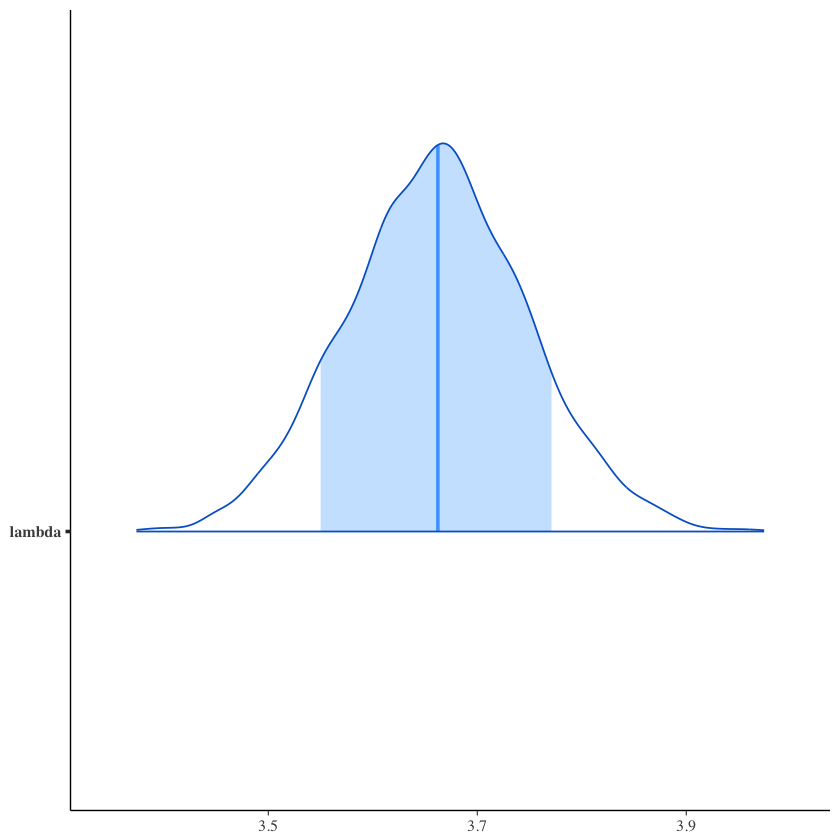

In [11]:
color_scheme_set("brightblue") # check out ?bayesplot::color_scheme_set
lambda_draws <- as.matrix(fit, pars = "lambda")
mcmc_areas(lambda_draws, prob = 0.8) # color 80% interval

## Compare posterior of lambda to the mean of the data
The model gets the mean right, but, as we'll see next, the model is quite bad at predicting the outcome.

In [12]:
means <- c("Posterior mean" = mean(lambda_draws), "Data mean" = mean(y))
print(means, digits = 3)

Posterior mean      Data mean 
          3.66           3.66 


## Graphical posterior predictive checks
Extract `y_rep` draws from the fitted model object

In [13]:
y_rep <- as.matrix(fit, pars = "y_rep")

# number of rows = number of post-warmup posterior draws
# number of columns = length(y)
dim(y_rep)

[1] 4000  500

## Compare histogram of `y` to histograms of several `y_rep`s
ppc = posterior predictive plot

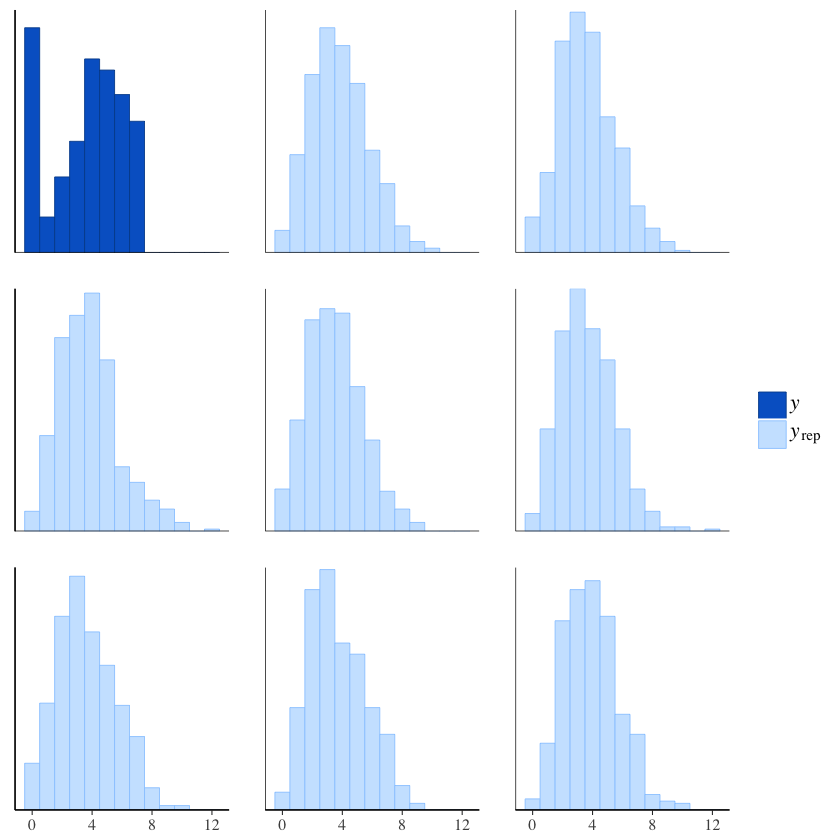

In [14]:
ppc_hist(y, y_rep[1:8, ], binwidth = 1)

## Compare density estimate of `y` to density estimates of a bunch of `y_rep`s

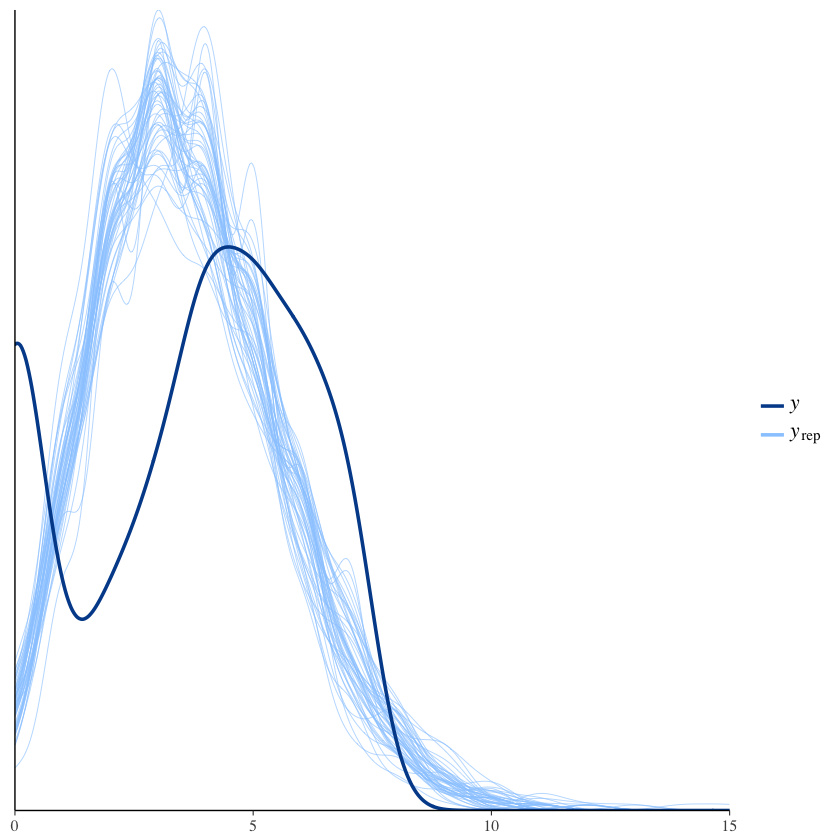

In [15]:
ppc_dens_overlay(y, y_rep[1:50, ])

## Compare proportion of zeros in `y` to the distribution of that proportion over all `y_rep`s

In [16]:
prop_zero <- function(x) mean(x == 0)
print(prop_zero(y))

[1] 0.202


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


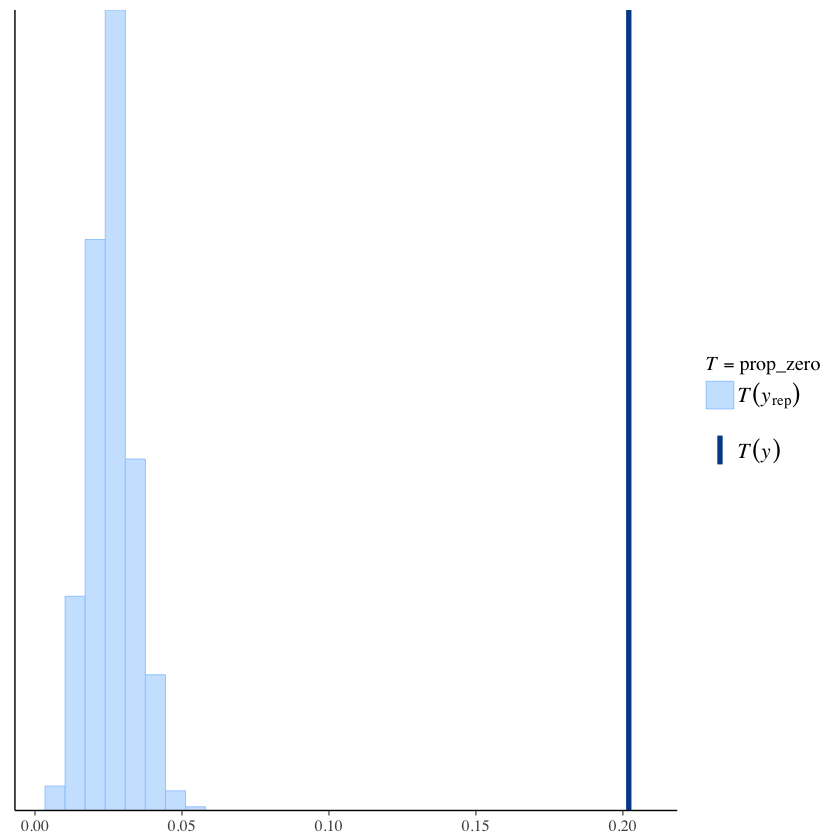

In [17]:
ppc_stat(y, y_rep, stat = "prop_zero")

## Some other checks
Looking at two statistics in a scatterplot:

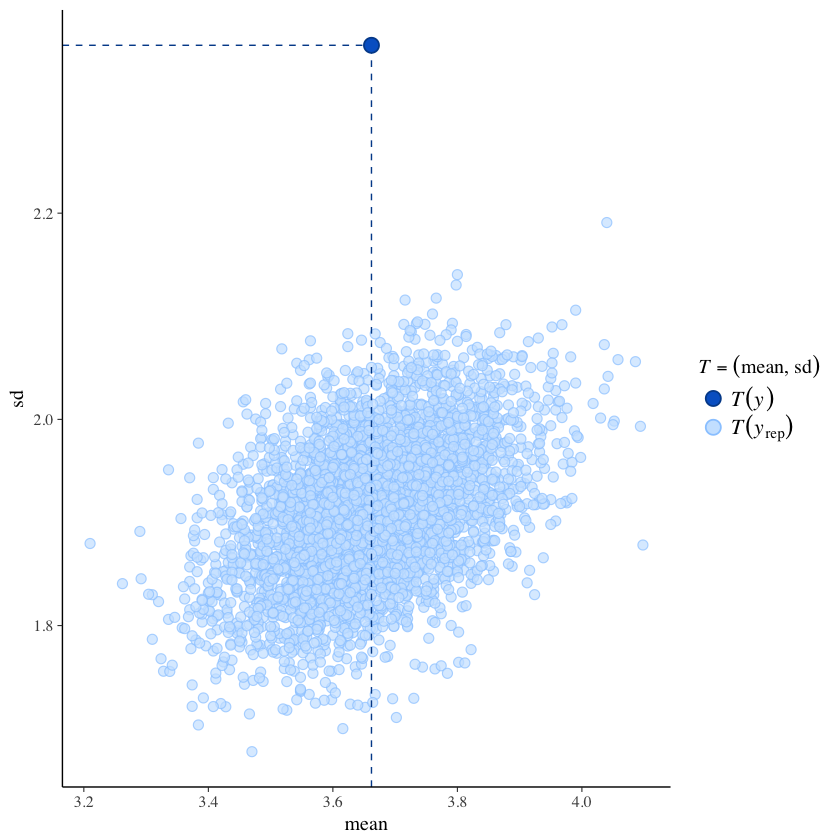

In [18]:
ppc_stat_2d(y, y_rep, stat = c("mean", "sd"))

## Distributions of predictive errors

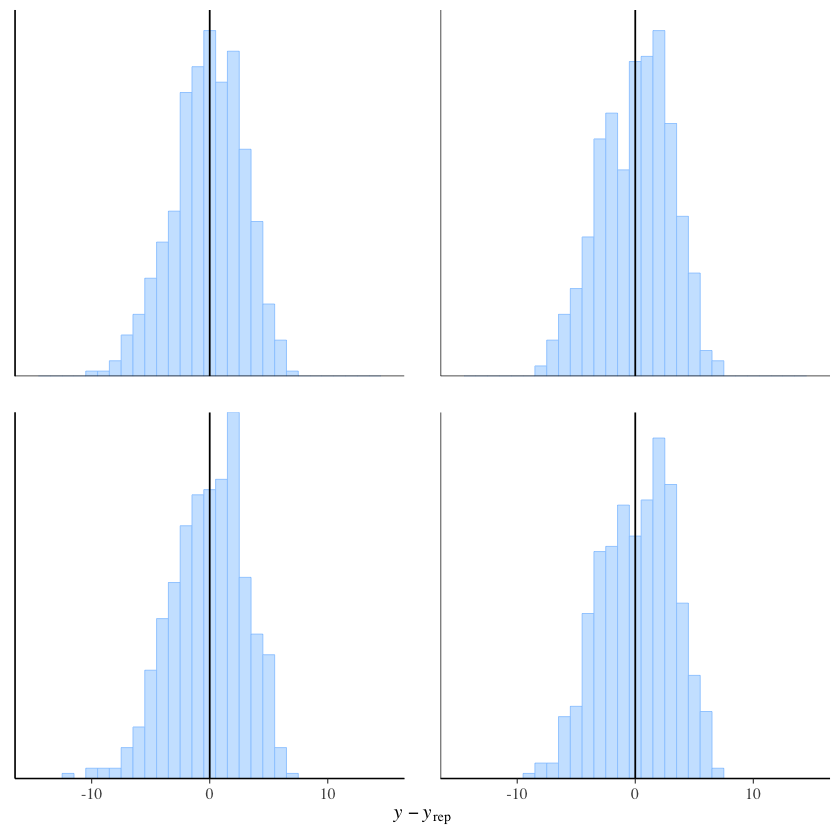

In [19]:
ppc_error_hist(y, y_rep[1:4, ], binwidth = 1) + 
  xlim(-15, 15) + 
  vline_0()

# Fit Poisson "hurdle" model (also with truncation from above)
---
This model says that there is some probability `theta` that `y` is zero and probability `1 - theta` that `y` is positive. Conditional on observing a positive `y`, we use a truncated Poisson:

        y[n] ~ poisson(lambda) T[1, U];

where `T[1, U]` indicates truncation with lower bound `1` and upper bound `U`, which for simplicity we'll _assume_ is `max(y)`.

In [20]:
writeLines(readLines("../stan/poisson-hurdle.stan"))

/* Stan program 
 * for Poisson "hurdle" model (also with upper truncation)
 * 
 * Note: for simplicity I assume that there is only one way to obtain
 * a zero, as opposed to some zero-inflated models where there are 
 * multiple processes that lead to a zero. So in this example, y is 
 * zero with probability theta and y is modeled as a truncated poisson
 * if greater than zero.
 */

data {
  int<lower=1> N;
  int<lower=0> y[N];
}
transformed data {
  int U = max(y);  // upper truncation point
}
parameters {
  real<lower=0,upper=1> theta; // Pr(y = 0)
  real<lower=0> lambda; // Poisson rate parameter (if y > 0)
}
model {
  lambda ~ exponential(0.2);
  
  for (n in 1:N) {
    if (y[n] == 0) {
      target += log(theta);  // log(Pr(y = 0))
    } else {
      target += log1m(theta);  // log(Pr(y > 0))
      y[n] ~ poisson(lambda) T[1,U];  // truncated poisson
    }
  }
}
generated quantities {
  int y_rep[N];    // Draws from posterior preditive dist
  real log_lik[N]; // Pointwise log-l

In [21]:
# second stan program
fit2 <- stan("../stan/poisson-hurdle.stan", data = list(y = y, N = N))

In file included from file9b313f67ebc6.cpp:8:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7:
In file included from /usr/local/miniconda3/envs/StanCon2018_Intro/lib/R/library/BH/include/boost/math/tools/config.hpp:13:
In file included from /usr/local/miniconda3/envs/S

Before looking at the posterior distribution, think about whether you expect `lambda` to be larger or smaller than the `lambda` estimated using the simpler Poisson model. 

In [22]:
print(fit2, pars = c("lambda", "theta"))

Inference for Stan model: poisson-hurdle.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd 2.5%  25% 50%  75% 97.5% n_eff Rhat
lambda  5.3       0 0.16 4.99 5.20 5.3 5.42  5.62  3934    1
theta   0.2       0 0.02 0.17 0.19 0.2 0.21  0.24  4000    1

Samples were drawn using NUTS(diag_e) at Wed Jan 24 00:03:11 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Compare posterior distributions of lambda from the two models

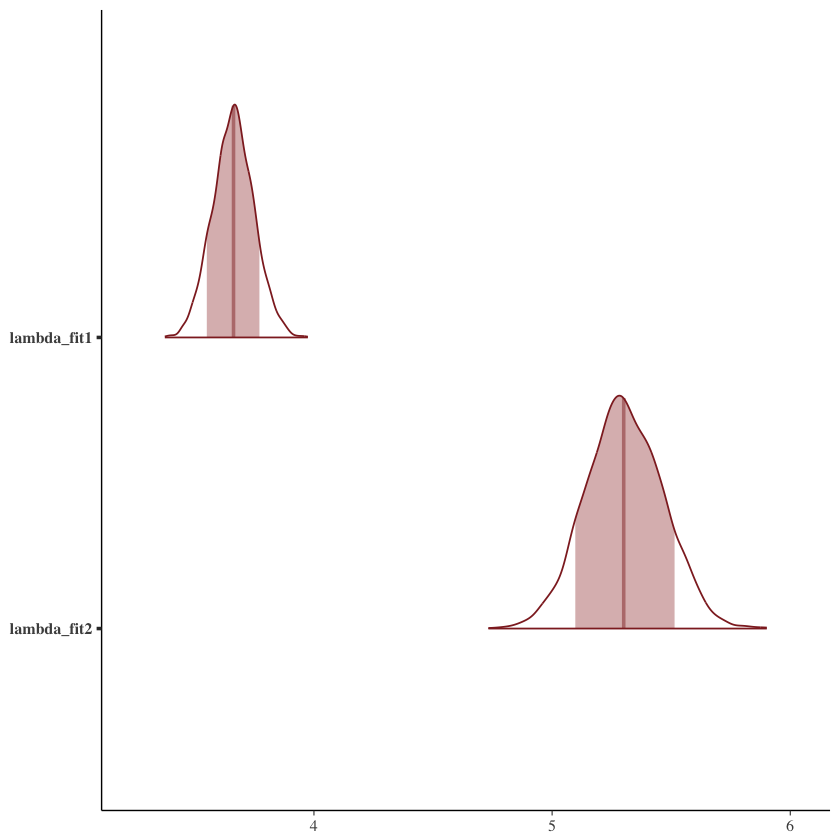

In [23]:
lambda_draws2 <- as.matrix(fit2, pars = "lambda")

lambdas <- cbind(lambda_fit1 = lambda_draws[, 1],
                 lambda_fit2 = lambda_draws2[, 1])

color_scheme_set("red")
mcmc_areas(lambdas, prob = 0.8) # color 80% interval

## Posterior predictive checks again
Same plots as before (and a few others), but this time using `y_rep` from `fit2`. Everything looks much more reasonable.

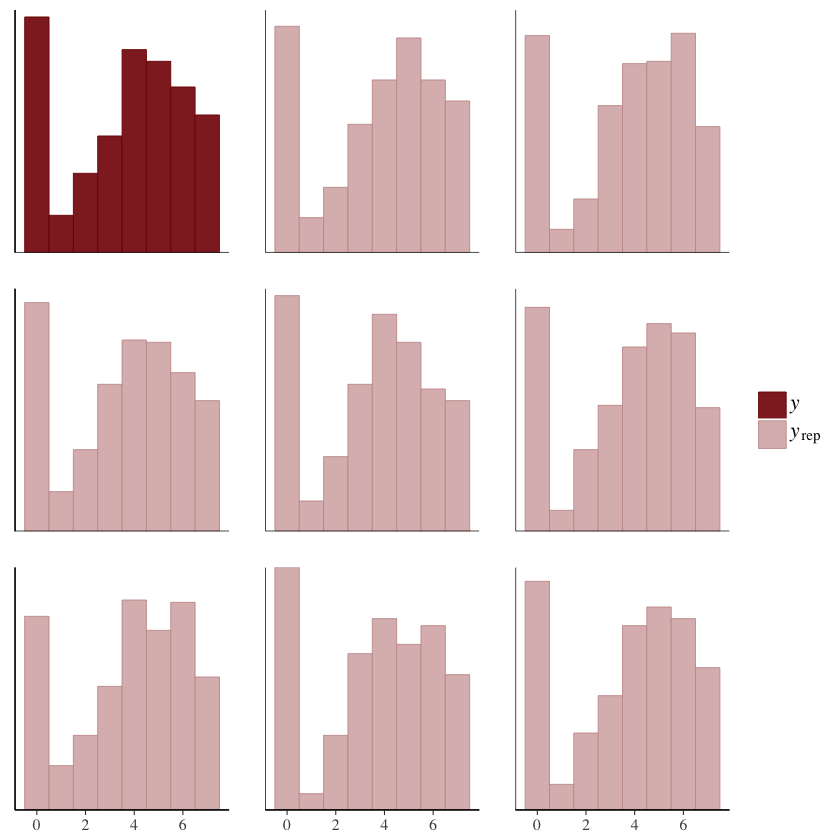

In [24]:
y_rep2 <- as.matrix(fit2, pars = "y_rep")
ppc_hist(y, y_rep2[1:8, ], binwidth = 1)

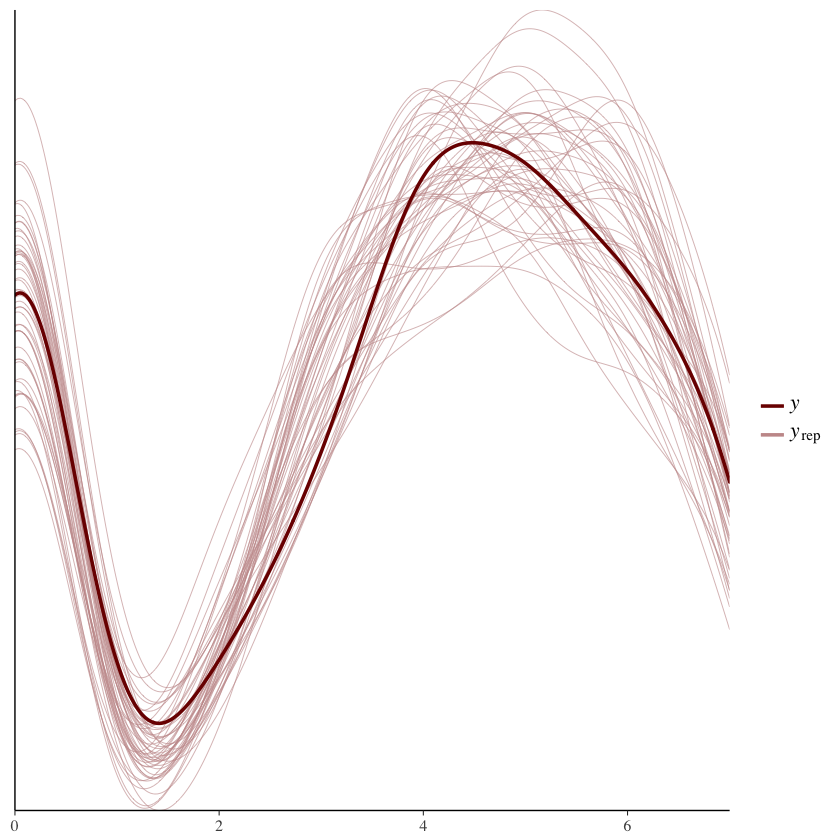

In [25]:
ppc_dens_overlay(y, y_rep2[1:50, ])

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


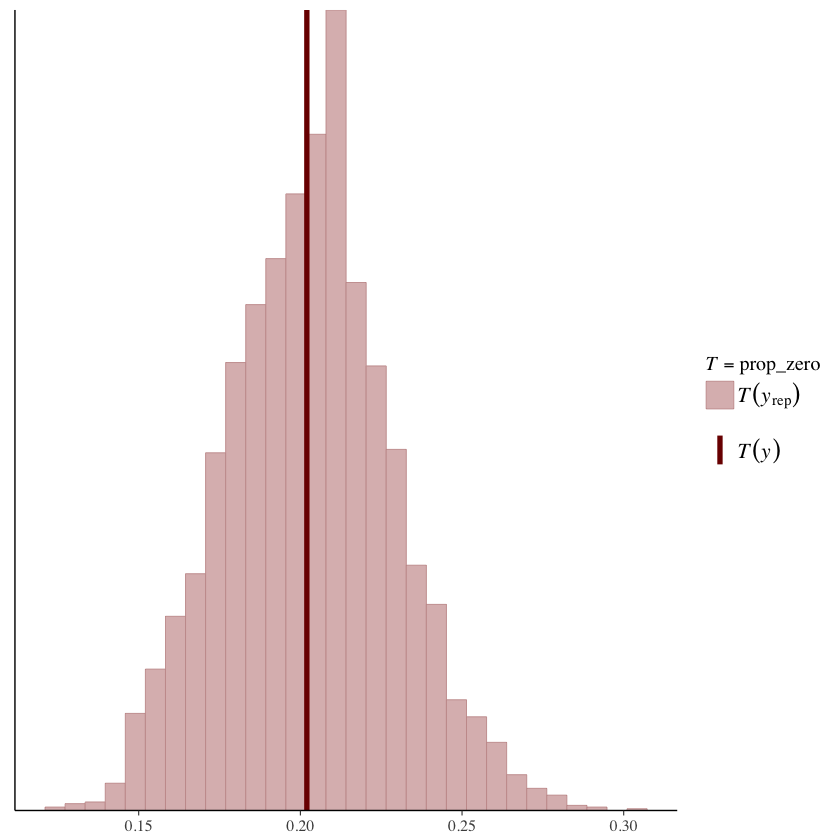

In [26]:
ppc_stat(y, y_rep2, stat = "prop_zero")

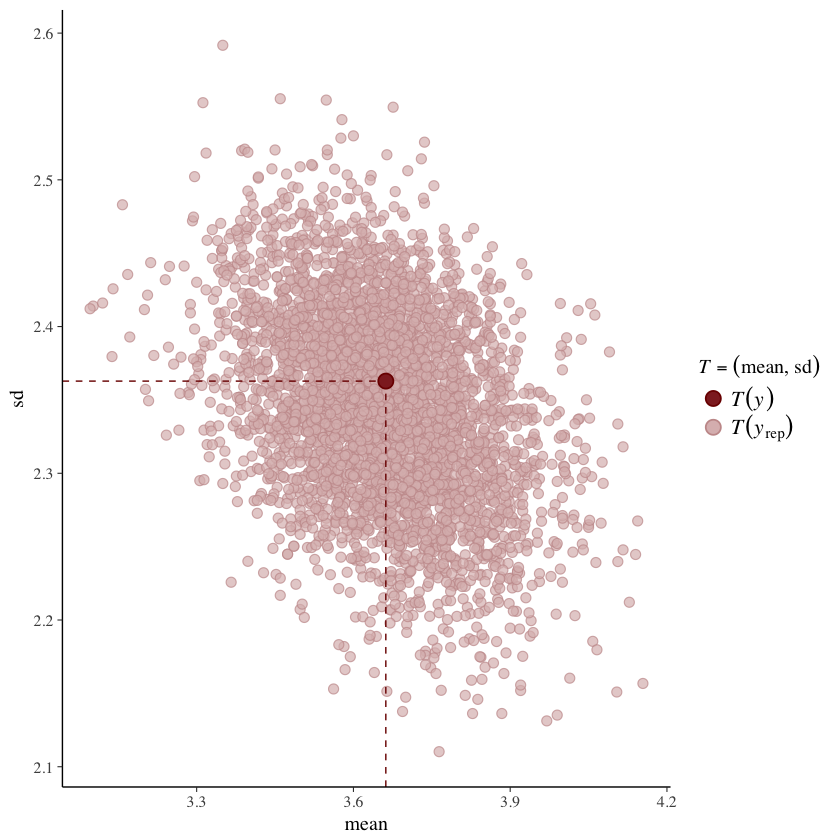

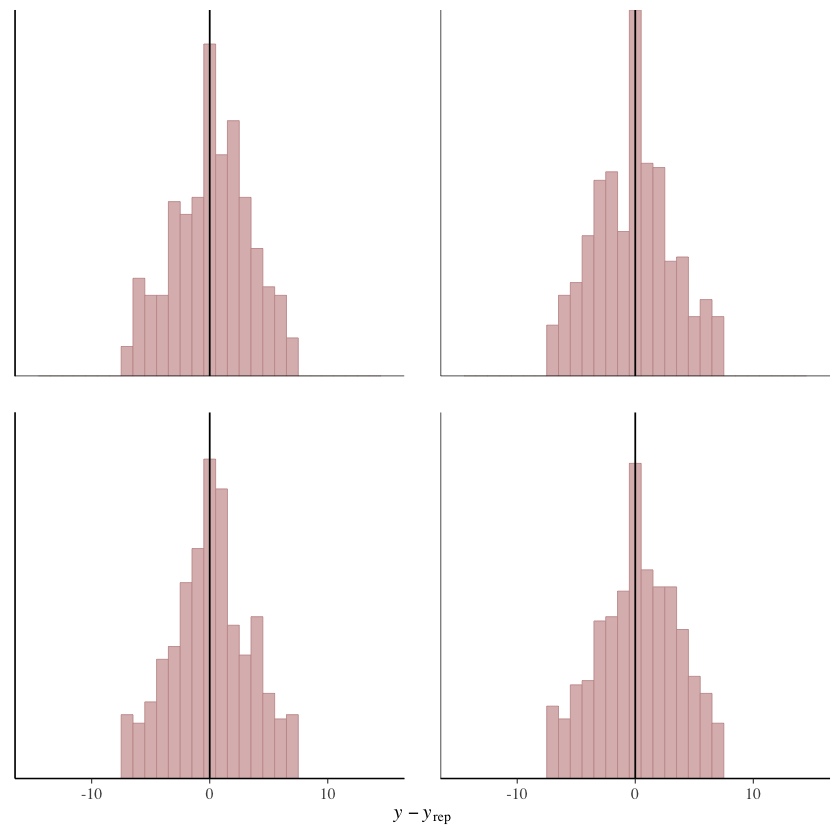

In [27]:
ppc_stat_2d(y, y_rep2, stat = c("mean", "sd"))
ppc_error_hist(y, y_rep2[sample(nrow(y_rep2), 4), ], binwidth = 1) + 
  xlim(-15, 15) +
  vline_0()

## How about the predictive performance with LOO?
Model 2 is a clear winner in the predictive performance.

In [28]:
log_lik1 <- extract_log_lik(fit)
(loo1<-loo(log_lik1))
log_lik2 <- extract_log_lik(fit2)
(loo2<-loo(log_lik2))
compare(loo1, loo2)

Computed from 4000 by 500 log-likelihood matrix

         Estimate   SE
elpd_loo  -1208.0 17.5
p_loo         1.5  0.1
looic      2415.9 35.0

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

Computed from 4000 by 500 log-likelihood matrix

         Estimate   SE
elpd_loo   -991.9  9.3
p_loo         2.0  0.1
looic      1983.9 18.7

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

elpd_diff        se 
    216.0      22.1 

---

---

---

---

---

---

---

---

---

---